# Dogs vs Cats project

### Authors:
* **Ilan Simchon**
* **Kfir Zilbernagel**

 In this notebook we will work on the dogs vs cats project, we have 25,000 pictures of dogs and cats and our goal is to let the model train on 90% of them (train), and try to get the highest percentage of accuracy in the remaining 10% (test).
 
 during our work we will have to clean the pictures, turn them into pixel data, then we will try to lower our amount of dimensions with PCA (while maintaining the maximum classification capabilities of the models) to help the models run faster.
then we will try a variety of models and look for the best, using a variety of functions and hyper-parameters That we will help us achieve the best model 
#### Enjoy your reading!


## 


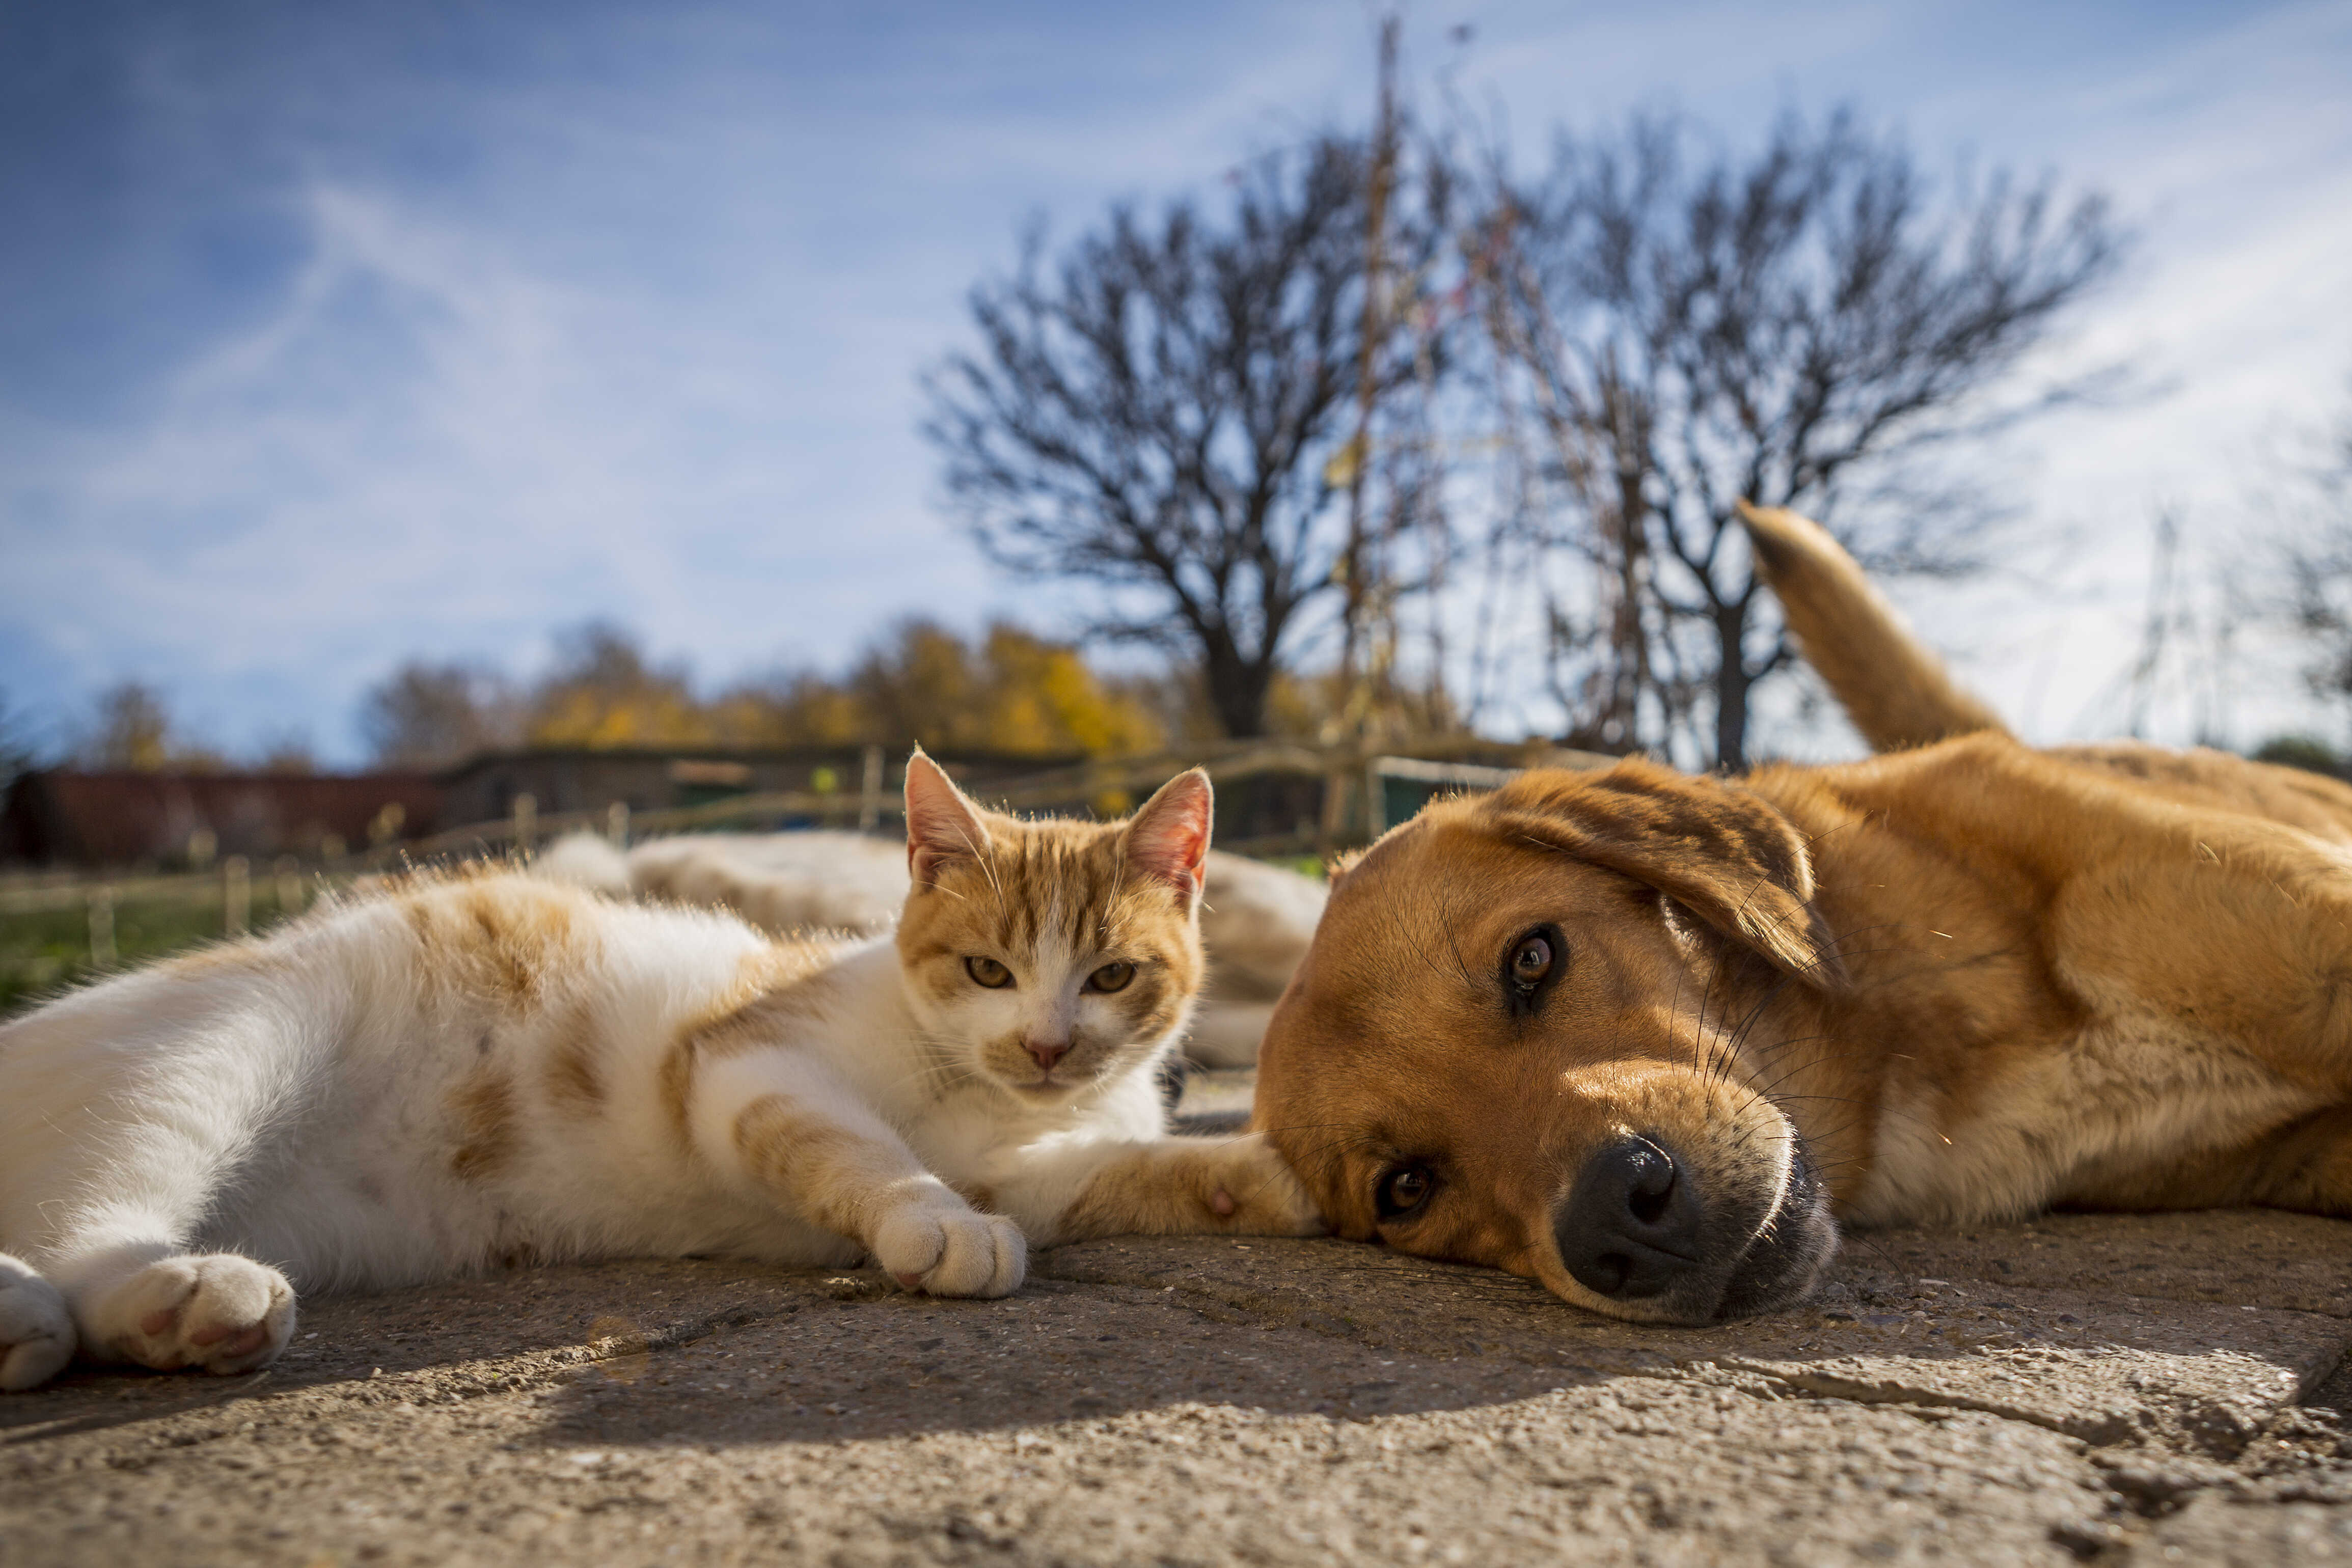

# Imports

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
import cv2
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from seaborn import color_palette
from sklearn.manifold import TSNE
from tensorflow.keras.utils import img_to_array
from sklearn.metrics import plot_confusion_matrix

import warnings                                     
warnings.filterwarnings("ignore")

## Loading the pictures

In [3]:
url = r'C:\לימודים\סמסטר ב\הדמיית נתונים\פרוייקט גמר\dogs-vs-cats\train\train'
titles = os.listdir(url)

In [4]:
category =[]
for title in titles:
    title = title.split('.')[0]
    if title == "cat":
        category.append(0)
    else:
        category.append(1)
categories = pd.DataFrame({'title': titles , 'category': category})

In [5]:
categories

,title,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


### 0 for a cat , 1 for a dog

#### Let's show few pictures

In [6]:
# Create figure with 2x2 sub-plots.
def plot_images(images, labels):
  fig, axes = plt.subplots(2, 2)
  fig.subplots_adjust(hspace=0.5 , wspace=0.3)

  for i, ax in enumerate(axes.flat):
    # Plot image
    ax.imshow(mpimg.imread(images[i]))
    
    # Plot label
    ax.set_xlabel('Label : %s' % labels[i])
        
        
  plt.show()

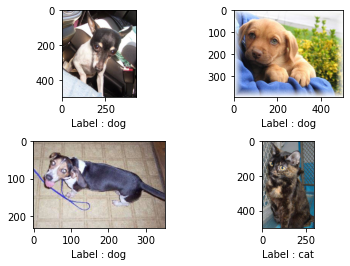

In [7]:
img_paths = []
img_labels = []
for i in range(10):
  # pick 4 random ids from the dataset
  rand_id = np.random.randint(0, len(titles))
  
  # get the img path from the id
  filename = categories.loc[rand_id, 'title'] 
  path = os.path.join(url, filename)
  img_paths.append(path)
  
  # get the img label from the id
  img_label = categories.loc[rand_id, 'category'] 
  if img_label == 1:
    img_labels.append('dog')
  else:
    img_labels.append('cat')
  
plot_images(img_paths, img_labels)

#### That is before cleaning data, let's claen it and making data frame

# Data cleaning

Our images are currently colored and therefore have three dimensions, we want to make them one dimension and make their size the same so that we do not have missing values, then we want to get the pixels of each image and build a data frame from them

We will make the images a uniform size of 25 * 25 (because this is what worked best in preliminary experiments)

In [191]:
pixels = []
for t in titles:
    file = os.path.join(url , t)
    img = Image.open(file)
    resize = img.resize((25,25))
    bw = resize.convert(mode='L')
    #temp = list(bw.getdata())
    temp = img_to_array(bw)
    pixels = pixels +[temp]
    bw.save(r'C:\לימודים\סמסטר ב\הדמיית נתונים\פרוייקט גמר\dogs-vs-cats\train\resize_bw\\' + t)

In [192]:
for i in range(0,25000):
    pixels[i] = pixels[i].reshape(25*25,)

We changed the shape of the fiscals of each single-locator image to put it in a row in the data frame, let's see it:

In [193]:
pixels[0].shape

(625,)

##### Making Data Frame

In [194]:
column = []
for i in range(0,25*25):
    column.append('pixel' + str(i))
    
df = pd.DataFrame(data = pixels , columns = column)
df['label'] = categories['category']

In [195]:
df

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel616,pixel617,pixel618,pixel619,pixel620,pixel621,pixel622,pixel623,pixel624,label
0,175.0,190.0,201.0,206.0,214.0,204.0,165.0,137.0,100.0,140.0,...,45.0,24.0,7.0,40.0,51.0,21.0,4.0,3.0,3.0,0
1,42.0,49.0,49.0,42.0,44.0,64.0,71.0,76.0,95.0,136.0,...,74.0,56.0,34.0,41.0,52.0,53.0,58.0,59.0,56.0,0
2,55.0,62.0,62.0,60.0,57.0,54.0,54.0,52.0,53.0,48.0,...,155.0,120.0,124.0,69.0,73.0,71.0,110.0,143.0,165.0,0
3,224.0,227.0,228.0,229.0,230.0,230.0,228.0,223.0,213.0,218.0,...,190.0,161.0,188.0,248.0,249.0,236.0,217.0,209.0,215.0,0
4,96.0,102.0,147.0,200.0,215.0,233.0,195.0,155.0,136.0,111.0,...,155.0,102.0,111.0,102.0,104.0,98.0,83.0,77.0,87.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,143.0,147.0,150.0,153.0,156.0,159.0,159.0,162.0,164.0,167.0,...,154.0,160.0,166.0,154.0,161.0,163.0,164.0,167.0,168.0,1
24996,90.0,89.0,87.0,91.0,96.0,88.0,98.0,106.0,107.0,91.0,...,61.0,45.0,13.0,22.0,51.0,80.0,86.0,85.0,83.0,1
24997,42.0,47.0,43.0,62.0,124.0,87.0,62.0,101.0,125.0,145.0,...,122.0,155.0,156.0,162.0,161.0,134.0,137.0,140.0,144.0,1
24998,240.0,162.0,110.0,92.0,85.0,90.0,85.0,97.0,95.0,101.0,...,137.0,137.0,136.0,122.0,105.0,98.0,104.0,111.0,120.0,1


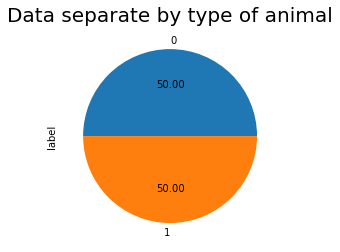

In [196]:
df["label"].value_counts().plot(kind = "pie", autopct = "%.2f" )
plt.title('Data separate by type of animal',fontsize=20)
plt.show()

### Our data is balanced, lets look the data

In [197]:
df.describe(include = 'all')

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel616,pixel617,pixel618,pixel619,pixel620,pixel621,pixel622,pixel623,pixel624,label
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000,25000.000000,25000.000000,25000.000000,25000.00000
mean,114.671160,115.740840,117.040480,118.152440,118.850480,119.731240,120.287320,120.803760,121.421920,121.744280,...,130.409040,129.573160,128.753000,127.836880,126.706520,125.58548,124.543640,122.741640,120.982720,0.50000
std,66.105387,65.397115,65.437735,65.308748,65.063592,64.876545,64.612434,64.401444,64.131915,63.920992,...,61.121056,61.398915,61.667003,61.666912,61.851793,61.92536,62.087007,62.374353,63.136231,0.50001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000
25%,61.000000,63.000000,64.000000,65.000000,66.000000,67.000000,69.000000,69.000000,70.000000,71.000000,...,85.000000,83.000000,82.000000,81.000000,79.000000,79.00000,77.000000,75.000000,72.000000,0.00000
50%,110.000000,112.000000,113.000000,115.000000,115.000000,116.000000,117.000000,118.000000,119.000000,119.500000,...,130.000000,129.000000,128.000000,127.000000,125.000000,124.00000,123.000000,121.000000,119.000000,0.50000
75%,163.000000,163.000000,164.000000,166.000000,166.000000,167.000000,167.000000,168.000000,168.000000,169.000000,...,175.000000,174.000000,174.000000,172.000000,172.000000,170.00000,169.000000,167.000000,166.000000,1.00000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.00000,255.000000,255.000000,255.000000,1.00000


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Columns: 626 entries, pixel0 to label
dtypes: float64(625), int64(1)
memory usage: 119.4 MB


In [199]:
df.isnull().sum(axis=1).sum(axis=0)

0

##### We have not missing data

#  Train test split & scaling

In [200]:
y = df['label']
X = df.drop('label' , axis=1)

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size=0.1, random_state=42)

In [202]:
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((22500, 625), (2500, 625), (22500,), (2500,))

### scaling

Because our data wave on the same scale does not have to balance it, but we decided to balance anyway in order to let the model deal with smaller numbers and thus perhaps speed up the calculation time

In [203]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255 

# Dimension reduction

## PCA

We will use PCA to lower dimensions. We can download a large number of dimensions that will not significantly harm the percentage of the variance of the data. Advantages of lowering dimensions:

* Run the code much faster.
* The model creates more inclusive.
* Allows visualization of the data to be made easier

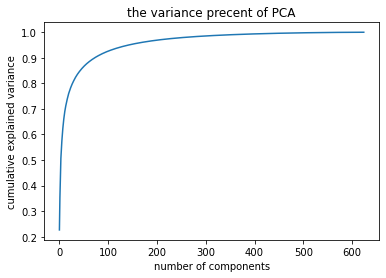

In [204]:
pca = PCA().fit(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.title("the variance precent of PCA")
plt.show()

In [205]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [206]:
X_train_pca.shape

(22500, 143)

We can notice that the number of dimensions is small from 10000 to 143, a very significant decrease while maintaining 95% of the variance, now we can work very easily with the models and find the best model

We will now try to see if the PCA model was able to classify the data itself using the first two dimensions (which contain the largest amount of information)

In [207]:
df_pca = pd.DataFrame(X_train_scaled ,y_train)
df_pca['First Dimension'] = X_train_pca[:,0]
df_pca['Second Dimension'] = X_train_pca[:,1] 

df_pca.reset_index(inplace=True)

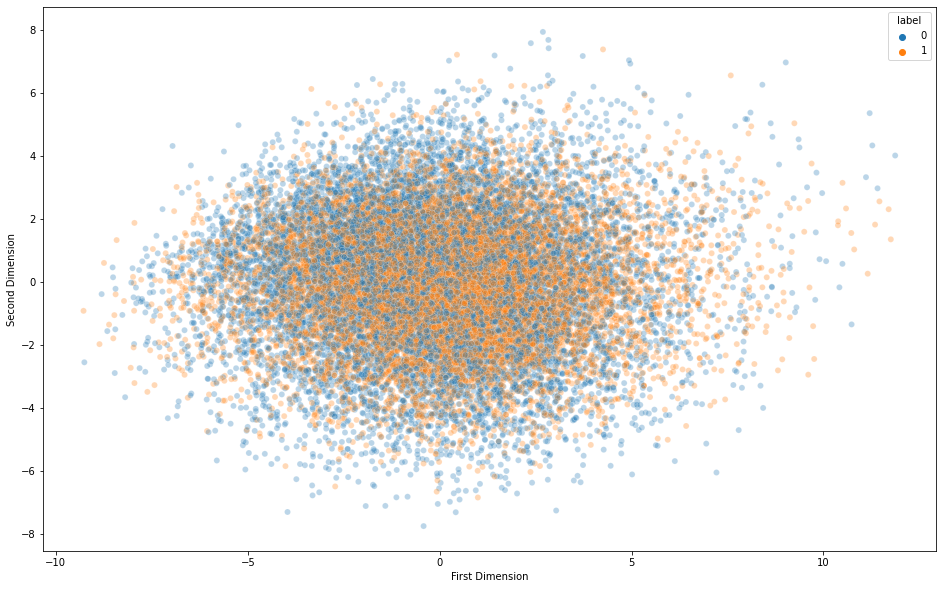

In [208]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="First Dimension", y="Second Dimension",
    hue = "label",
    data=df_pca,
    legend="full",
    alpha=0.3
)
plt.show()

##### We can see that the PCA fails to classify the values, this leads to the scores of the models being relatively low with the use of PCA,  let's try do Tsne

## Tsne

In [209]:
tsne = TSNE(n_components=2, init='pca', random_state=10)
X_tsne = tsne.fit_transform(X_train_scaled)

In [210]:
df_t = pd.DataFrame()
df_t["y"] = y_train
df_t["comp-1"] = X_tsne[:,0]
df_t["comp-2"] = X_tsne[:,1]

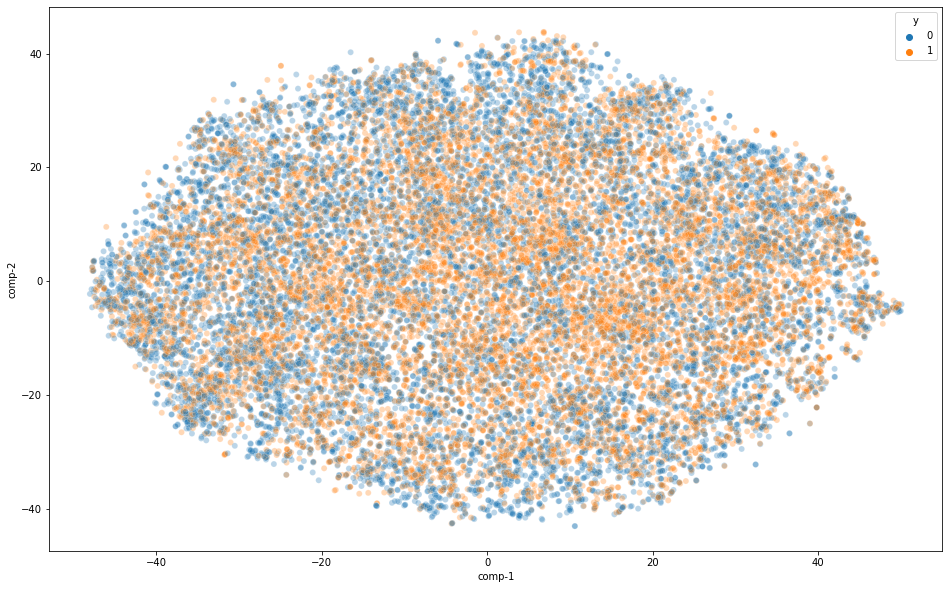

In [211]:
plt.figure(figsize=(16,10))

sns.scatterplot(
    x="comp-1", y="comp-2",
    hue = "y",
    #palette=sns.color_palette("Spectral", as_cmap=True),
    data=df_t,
    legend="full",
    alpha=0.3
)
plt.show()

### Indeed, Tsne also fails to classify the data,it's can implies the models will gives low scores. 

# Models

So we finished preparing the data for delivery to the models, reduced the dimensions to 631, and concluded from the visualization that the models would be very difficult to distinguish between dogs and cats and classify them correctly, but since we set the PCA to maintain 95% variance it can be concluded Good and so we will continue with the data with the low dimensions, but when we find the best model and test it on the test, we will test it on both the small test and the original test (without PCA) and thus we can also conclude about the level of PCA damage to our data

#### We will split our data for using a dummy model and other models without using  cross-validation, when we use cross-validation we will work with our whole data (without the test!)

In [212]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train_pca, y_train, test_size=0.20 , random_state=42)

### Dummy model

In [231]:
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_split, y_train_split)

predict = dummy.predict(X_test_split)
dummy.score(predict , y_test_split)

0.5

#### This grade is 50% because our data is balanced

### K-NN

In [214]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
score = []
ks = list(range(1,30,2))
for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv = cross_val_score(knn , X_train_pca , y_train , cv = kf , scoring = 'accuracy')
    score.append(cv.mean())
data = {'k': ks , 'score': score}
grades = pd.DataFrame(data) 
grades.set_index('k')

,score
k,
1,0.568222
3,0.580044
5,0.592622
7,0.601689
9,0.602667
11,0.602000
13,0.606133
15,0.607956
17,0.604711


In [215]:
grades[grades['score'] == max(grades['score'])].set_index('k')

,score
k,
29,0.6116


##### The score of Decision Tree is 61% with k = 29

### Desicion Tree

In [216]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
DecisionTree = DecisionTreeClassifier(max_depth=50)

scores = cross_val_score(DecisionTree, X_train_pca, y_train, cv=5, scoring='accuracy')

print("The score of Decision Tree is:" + str(scores.mean()))

The score of Decision Tree is:0.5468444444444445


### Random Forest

In [217]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
forest = RandomForestClassifier(n_estimators=100 , n_jobs = -1, random_state =42, max_depth=50)

scores_rf = cross_val_score(forest, X_train_pca, y_train, cv=4, scoring='accuracy')

print("The score of random forest is:" + str(scores_rf.mean()))

The score of random forest is:0.6121777777777777


### XGBoost

In [218]:
xgboost = XGBClassifier(objective='binary:logistic', missing=1, seed=42)
xgb_classifier = xgboost.fit(X_train_split,
                    y_train_split,
                    verbose=True,
                    early_stopping_rounds=10,
                    eval_metric='aucpr',
                    eval_set=[(X_test_split,y_test_split)])



[0]	validation_0-aucpr:0.57915
[1]	validation_0-aucpr:0.59215
[2]	validation_0-aucpr:0.59984
[3]	validation_0-aucpr:0.60519
[4]	validation_0-aucpr:0.60773
[5]	validation_0-aucpr:0.61597
[6]	validation_0-aucpr:0.62166
[7]	validation_0-aucpr:0.62075
[8]	validation_0-aucpr:0.62669
[9]	validation_0-aucpr:0.62451
[10]	validation_0-aucpr:0.62307
[11]	validation_0-aucpr:0.62463
[12]	validation_0-aucpr:0.62418
[13]	validation_0-aucpr:0.62406
[14]	validation_0-aucpr:0.62710
[15]	validation_0-aucpr:0.62851
[16]	validation_0-aucpr:0.63263
[17]	validation_0-aucpr:0.63226
[18]	validation_0-aucpr:0.63041
[19]	validation_0-aucpr:0.63229
[20]	validation_0-aucpr:0.63274
[21]	validation_0-aucpr:0.63280
[22]	validation_0-aucpr:0.63643
[23]	validation_0-aucpr:0.63898
[24]	validation_0-aucpr:0.64117
[25]	validation_0-aucpr:0.63979
[26]	validation_0-aucpr:0.64052
[27]	validation_0-aucpr:0.64200
[28]	validation_0-aucpr:0.64251
[29]	validation_0-aucpr:0.64357
[30]	validation_0-aucpr:0.64267
[31]	validation_0-

In [219]:
print('The score of xgboost:' , xgb_classifier.best_score , 'with' ,  xgb_classifier.best_iteration,  'rounds')

The score of xgboost: 0.6521376066060489 with 48 rounds


## AdaBoost

In [220]:
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=15), n_estimators=200)
AdaBoost.fit(X_train_split , y_train_split)
y_pred = AdaBoost.predict(X_test_split)
metrics.accuracy_score(y_pred, y_test_split)

0.5762222222222222

##### The score of adaboost is 57%

### Voting classifier

A Voting Classifier is a machine learning model that trains on an ensemble of numerous models and predicts an output (class) based on their highest probability of chosen class as the output. It simply aggregates the findings of each classifier passed into Voting Classifier and predicts the output class based on the highest majority of voting. The idea is instead of creating separate dedicated models and finding the accuracy for each them, we create a single model which trains by these models and predicts output based on their combined majority of voting for each output class.

Voting Classifier supports two types of votings.

In [221]:
estimators=[('K-NN' , knn),('RF',forest),('DT', DecisionTree),('ADA',AdaBoost) , ('xgb' , xgboost)]

#### Hard voting

Hard Voting: In hard voting, the predicted output class is a class with the highest majority of votes i.e the class which had the highest probability of being predicted by each of the classifiers. Suppose three classifiers predicted the output class(A, A, B), so here the majority predicted A as output. Hence A will be the final prediction.

In [222]:
vot_hard = VotingClassifier(estimators = estimators, voting ='hard')
vot_hard.fit(X_train_split , y_train_split)
y_pred = vot_hard.predict(X_test_split)
accuracy_score = metrics.accuracy_score(y_test_split, y_pred)
print("The accuracy score of Hard Voting is:"+str(accuracy_score))

The accuracy score of Hard Voting is:0.6371111111111111


#### Soft voting

Soft Voting: In soft voting, the output class is the prediction based on the average of probability given to that class. Suppose given some input to three models, the prediction probability for class A = (0.30, 0.47, 0.53) and B = (0.20, 0.32, 0.40). So the average for class A is 0.4333 and B is 0.3067, the winner is clearly class A because it had the highest probability averaged by each classifier.

In [223]:
vot_soft = VotingClassifier(estimators = estimators, voting ='soft')
vot_soft.fit(X_train_split, y_train_split)
y_pred = vot_soft.predict(X_test_split)
accuracy_score = metrics.accuracy_score(y_test_split, y_pred)
print("The accuracy score of Soft Voting is:"+str(accuracy_score))

The accuracy score of Soft Voting is:0.6144444444444445


# Test

### Our best model is xgboost with 0.65%, lets check the test!

We will examine the test with PCA and then we will examine it without PCA and thus we can see how much the reduction in dimensions affected the score and we will conclude from this whether it would have been profitable to use PCA


### Test without PCA

In [232]:
xgboost_pca = XGBClassifier(objective='binary:logistic', missing=1, seed=42)
xgb_classifier_pca = xgboost_pca.fit(X_train_pca,
                    y_train,
                    verbose=True,
                    early_stopping_rounds=10,
                    eval_metric='aucpr',
                    eval_set=[(X_test_pca,y_test)])

[0]	validation_0-aucpr:0.54141
[1]	validation_0-aucpr:0.57385
[2]	validation_0-aucpr:0.58379
[3]	validation_0-aucpr:0.58814
[4]	validation_0-aucpr:0.58996
[5]	validation_0-aucpr:0.59478
[6]	validation_0-aucpr:0.61280
[7]	validation_0-aucpr:0.62203
[8]	validation_0-aucpr:0.62217
[9]	validation_0-aucpr:0.62416
[10]	validation_0-aucpr:0.62746
[11]	validation_0-aucpr:0.62936
[12]	validation_0-aucpr:0.62620
[13]	validation_0-aucpr:0.62100
[14]	validation_0-aucpr:0.62289
[15]	validation_0-aucpr:0.62557
[16]	validation_0-aucpr:0.62484
[17]	validation_0-aucpr:0.62849
[18]	validation_0-aucpr:0.62927
[19]	validation_0-aucpr:0.62872
[20]	validation_0-aucpr:0.63331
[21]	validation_0-aucpr:0.63148
[22]	validation_0-aucpr:0.63034
[23]	validation_0-aucpr:0.63040
[24]	validation_0-aucpr:0.62936
[25]	validation_0-aucpr:0.63220
[26]	validation_0-aucpr:0.63372
[27]	validation_0-aucpr:0.63425
[28]	validation_0-aucpr:0.63378
[29]	validation_0-aucpr:0.63456
[30]	validation_0-aucpr:0.63431
[31]	validation_0-

In [233]:
print('The score of xgboost on the test with PCA is:' , xgb_classifier_pca.best_score , 'with' ,  xgb_classifier_pca.best_iteration,  'rounds')

The score of xgboost on the test with PCA is: 0.6533947850274995 with 43 rounds


### Confusion Matrix

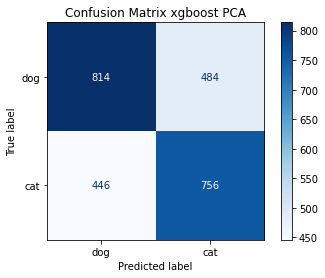

In [226]:
plot_confusion_matrix(xgb_classifier_pca ,X_test_pca , y_test, display_labels=["dog", "cat"], cmap =  plt.cm.Blues )
plt.title("Confusion Matrix xgboost PCA")
plt.show()

#### In the test we reached 65 percent accuracy, this is a low score but we watched it thanks to the visualization we performed on the PCA, we will now run the test without PCA and we will be able to examine the gaps that PCA caused

### Test without PCA

In [227]:
xgboost_without_pca = XGBClassifier(objective='binary:logistic', missing=1, seed=42)
xgb_classifier_not_pca = xgboost_without_pca.fit(X_train_scaled,
                    y_train,
                    verbose=True,
                    early_stopping_rounds=10,
                    eval_metric='aucpr',
                    eval_set=[(X_test_scaled,y_test)])

[0]	validation_0-aucpr:0.55773
[1]	validation_0-aucpr:0.58072
[2]	validation_0-aucpr:0.59643
[3]	validation_0-aucpr:0.60930
[4]	validation_0-aucpr:0.63017
[5]	validation_0-aucpr:0.63398
[6]	validation_0-aucpr:0.64161
[7]	validation_0-aucpr:0.64178
[8]	validation_0-aucpr:0.64342
[9]	validation_0-aucpr:0.65170
[10]	validation_0-aucpr:0.65789
[11]	validation_0-aucpr:0.65727
[12]	validation_0-aucpr:0.65527
[13]	validation_0-aucpr:0.66061
[14]	validation_0-aucpr:0.66244
[15]	validation_0-aucpr:0.65952
[16]	validation_0-aucpr:0.65911
[17]	validation_0-aucpr:0.65990
[18]	validation_0-aucpr:0.65993
[19]	validation_0-aucpr:0.66051
[20]	validation_0-aucpr:0.65915
[21]	validation_0-aucpr:0.65985
[22]	validation_0-aucpr:0.65964
[23]	validation_0-aucpr:0.66077
[24]	validation_0-aucpr:0.66186


In [228]:
print('The score of xgboost on the test without PCA is:' , xgb_classifier_not_pca.best_score , 'with' ,  xgb_classifier_not_pca.best_iteration,  'rounds')

The score of xgboost on the test without PCA is: 0.662443887806131 with 14 rounds


### Confusion Matrix

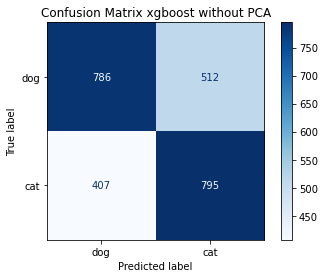

In [229]:
plot_confusion_matrix(xgb_classifier_not_pca ,X_test_scaled , y_test, display_labels=["dog", "cat"], cmap =  plt.cm.Blues )
plt.title("Confusion Matrix xgboost without PCA")
plt.show()

### The model without PCA gives us only one percent more, so we can conclude that it was profitable to use PCA that helped us achieve great run times, taught us about the data and helped us predict what results we will get in models, so we can be satisfied that we used PCA almost without hurting the model

# Thanks for reading